In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

In [53]:
train = pd.read_csv('train.csv', na_values=-1)
test = pd.read_csv('test.csv', na_values=-1)

In [54]:
train.isnull().values.any()

True

In [55]:
features = train.drop(['id','target'], axis=1).values
targets = train.target.values

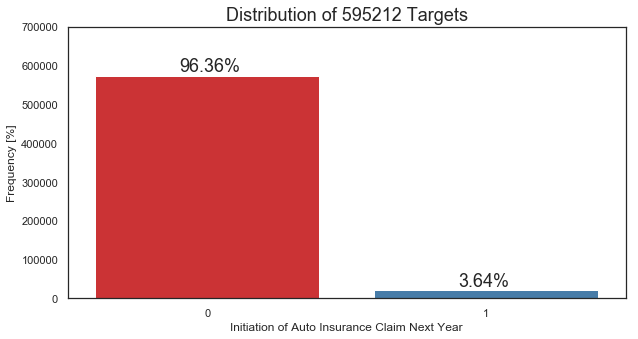

In [56]:
ax = sns.countplot(x = targets, palette="Set1")
sns.set(font_scale=1.5)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(10,5)
ax.set_ylim(top=700000)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(targets)), (p.get_x() + 0.3, p.get_height() + 10000))
    
plt.title('Distribution of 595212 Targets')
plt.xlabel('Initiation of Auto Insurance Claim Next Year')
plt.ylabel('Frequency [%]')
plt.show()

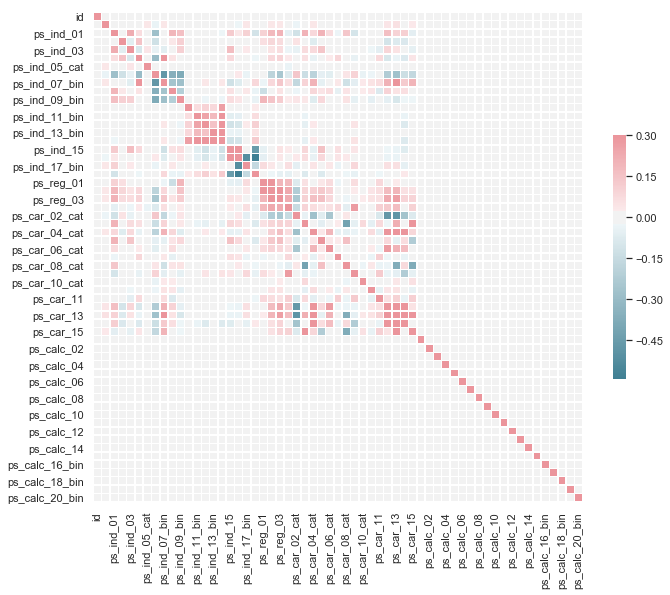

In [57]:
sns.set(style= 'white')

corr = train.corr()

f, ax = plt.subplots(figsize=(11,9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [58]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    # assertは条件を満たすときTrueを返す
    assert(len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:,2], -1*all[:,1]))]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score

In [59]:
unwanted = train.columns[train.columns.str.startswith('ps_calc_')]

In [60]:
train = train.drop(unwanted, axis=1)
test = test.drop(unwanted, axis=1)

In [61]:
kfold = 5
skf = StratifiedKFold(n_splits=kfold, random_state=42)

In [62]:
param = {
    'min_child_weight' : 10.0,
    'objective': 'binary:logistic',
    'max_depth': 7,
    'max_delta_step':1.8,
    'colsample_bytree':0.4,
    'subsample': 0.8,
    'eta': 0.025,
    'num_boost_round' : 700
}

X = train.drop(['id', 'target'], axis=1).values
y = train.target.values
test_id = test.id.values
test = test.drop('id', axis=1)

In [63]:
sub = pd.DataFrame()
sub['id'] = test_id
sub['target'] = np.zeros_like(test_id)

In [64]:
for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    print('[Fold %d/%d]' % (i + 1, kfold))
    X_train , X_valid = X[train_index], X[test_index]
    y_train , y_valid = y[train_index], y[test_index]
    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)
    d_test = xgb.DMatrix(test.values)
    watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    mdl = xgb.train(param, d_train, 1600, watchlist, early_stopping_rounds=70, feval=gini_xgb, maximize=True, verbose_eval=100)
    
    print('[Fold %d/%d Prediction:]' % (i + 1, kfold))
    p_test = mdl.predict(d_test, ntree_limit=mdl.best_ntree_limit)
    sub['target'] += p_test/kfold

[Fold 1/5]
[0]	train-error:0.036447	valid-error:0.036449	train-gini:0.042855	valid-gini:0.050046
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
[100]	train-error:0.036447	valid-error:0.036449	train-gini:0.324629	valid-gini:0.264985
[200]	train-error:0.036443	valid-error:0.036449	train-gini:0.363819	valid-gini:0.273494
[300]	train-error:0.036426	valid-error:0.036449	train-gini:0.400032	valid-gini:0.278825
[400]	train-error:0.036418	valid-error:0.036441	train-gini:0.426669	valid-gini:0.281024
[500]	train-error:0.036416	valid-error:0.036449	train-gini:0.448913	valid-gini:0.281097
Stopping. Best iteration:
[479]	train-error:0.036416	valid-error:0.036441	train-gini:0.443936	valid-gini:0.281704

[Fold 1/5 Prediction:]
[Fold 2/5]
[0]	train-error:0.036447	valid-error:0.036449	train-gini:0.04184	valid-gini:0.052138
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping

In [65]:
sub.to_csv('StratifiedKFold.csv', index=False)